In [4]:
from tme6 import CirclesData
import torch as th
import numpy as np

def meanCrossEntropyLoss(Y,Y_):
    mce = - th.mean(Y*th.log(Y_),1,keepdim=True)
    return mce

def loss_accuracy(Y,Y_):
    loss = meanCrossEntropyLoss(Y,Y_)
    N = Y.shape[0]
    _, indY = th.max(Y,1)
    _, ind_Y = th.max(Y_,1)
    tptn = th.sum(indY == ind_Y) * 100
    accuracy = tptn/float(N)
    return loss,accuracy
    
def init_params(nx,nh,ny,sigma=0.3):
    params = {}
    params['Wh'] = th.randn(nh,nx)*sigma
    params['bh'] = th.randn(nh,1)*sigma
    params['Wy'] = th.randn(ny,nh)*sigma
    params['by'] = th.randn(ny,1)*sigma
    return params

def softmax(_y):
    z = th.sum(th.exp(_y),1,keepdim=True)
    return th.exp(_y)/z.expand_as(_y)

def forward(X,params):
    N = X.shape[0]
    nh,nx = params['Wh'].shape
    ny,nh = params['Wy'].shape
    Wht = params['Wh'].t()
    Wyt = params['Wy'].t()
    bh = params['bh']
    by = params['by']
    
    H_= X.mm(Wht) + bh.expand(nh,N).t()
    H = th.tanh(H_)
    Y_ = H.mm(Wyt) + by.expand(ny,N).t()
    Yh = softmax(Y_)
    
    params['X'] = X
    params['H_']  = H_
    params['H'] = H
    params['Y_']  = Y_
    params['Yh'] = Yh
    return params

def print_params(params):
    keys = params.keys()
    X = params['X'] if 'X' in keys else None
    Y = params['Y'] if 'Y' in keys else None
    Wh = params['Wh'] if 'Wh' in keys else None
    bh = params['bh'] if 'bh' in keys else None
    H_ = params['H_'] if 'H_' in keys else None
    H = params['H'] if 'H' in keys else None
    Wy = params['Wy'] if 'Wy' in keys else None
    by = params['by'] if 'by' in keys else None
    Y_ = params['Y_'] if 'Y_' in keys else None
    Yh = params['Yh'] if 'Yh' in keys else None
    print ( '\
X: {}Y: {}\
Wh: {}bh: {}\
XWht+bh=H_: {}tahn(H_)=H: {}\
Wy: {}by: {}\n\
XWyt+by=Y_: {}Softmax(Y_)=Yh: {}\n\
'.format(X,Y,Wh,bh,H_,H,Wy,by,Y_,Yh) )
    

In [6]:
batch_size = 3
params={}
data = CirclesData()
Xtrain = data.Xtrain
N = Xtrain.shape[0] 
nx = Xtrain.shape[1]
# hidden units
nh = 4
# classes X
ny = 2
#batch_size = N
params = init_params(nx,nh,ny)
params = forward(Xtrain[0:batch_size], params)
Y = data.Ytrain[0:batch_size]
params['Y'] = Y
loss,acc = loss_accuracy(Y,params['Y_'])
print_params(params)
print('MCE loss: {}, accuracy: {}'.format(loss,acc))

X: 
 0.9042 -0.1938
 0.9349  0.0266
 1.2184 -0.0958
[torch.FloatTensor of size 3x2]
Y: 
 1  0
 1  0
 1  0
[torch.FloatTensor of size 3x2]
Wh: 
 0.1109  0.1859
 0.3025 -0.2389
-0.0404 -0.4613
 0.2526 -0.0468
[torch.FloatTensor of size 4x2]
bh: 
 0.2257
-0.0286
-0.2388
-0.6001
[torch.FloatTensor of size 4x1]
XWht+bh=H_: 
 0.2900  0.2913 -0.1859 -0.3627
 0.3344  0.2479 -0.2888 -0.3652
 0.3431  0.3629 -0.2438 -0.2879
[torch.FloatTensor of size 3x4]
tahn(H_)=H: 
 0.2821  0.2833 -0.1838 -0.3475
 0.3225  0.2430 -0.2811 -0.3498
 0.3302  0.3478 -0.2391 -0.2802
[torch.FloatTensor of size 3x4]
Wy: 
 0.0308 -0.1972  0.0997  0.2369
 0.0522 -0.1701  0.3811  0.2591
[torch.FloatTensor of size 2x4]
by: 
 0.8328
-0.2246
[torch.FloatTensor of size 2x1]

XWyt+by=Y_: 
 0.6849 -0.4181
 0.6839 -0.4468
 0.6841 -0.4302
[torch.FloatTensor of size 3x2]
Softmax(Y_)=Yh: 
 0.7508  0.2492
 0.7560  0.2440
 0.7529  0.2471
[torch.FloatTensor of size 3x2]


MCE loss: 
nan
nan
nan
[torch.FloatTensor of size 3x1]
, accura

# compute forward with tensors

## Remarks
* doint Xtrain[0:1] returns a size 1XN tensor while doing so Xtrain[0] return a size N tensor.
* don't mix numpy and torch (too much)
* $XW^t$ instead of $WX^t$ because $X >> W$ (for large batches).
* the previus point implies that you must expand bias by rows.


In [7]:
# Backward

def print_grads(grads):
    keys = grads.keys()
    
    DYh = grads['DYh'] if 'DYh' in keys else None
    DWy = grads['DWy'] if 'DWy' in keys else None
    Dby = grads['Dby'] if 'Dby' in keys else None
    DH_ = grads['DH_'] if 'DH_' in keys else None
    DWh = grads['DWh'] if 'DWh' in keys else None
    Dbh = grads['Dbh'] if 'Dbh' in keys else None
    print ( '\
DYh: {}DWy: {}Dby: {}DH_: {}DWh: {}Dbh: {}\
'.format(DYh,DWy,Dby,DH_,DWh,Dbh) )

def backward(params):
    grads = {}
    Y  = params['Y']
    Yh = params['Yh']
    X  = params['X']
    H  = params['H']
    Wy = params['Wy']
    
    DYh = Yh-Y
    DWy = DYh.t().mm(H)
    Dby = th.sum(DYh,0,keepdim=True).t()
    DH_ = DYh.mm(Wy)*(1-H**2)
    DWh = DH_.t().mm(X)
    Dbh = th.sum(DH_,0,keepdim=True).t()
    
    grads['DYh'] = DYh
    grads['DWy'] = DWy
    grads['Dby'] = Dby
    grads['DH_'] = DH_
    grads['DWh'] = DWh
    grads['Dbh'] = Dbh
    return grads

def sgd(params, grads, eps=1e-3):
    DWy = grads['DWy']
    Dby = grads['Dby']
    DWh = grads['DWh']
    Dbh = grads['Dbh']
    
    Wy = params['Wy']
    by = params['by']
    Wh = params['Wh']
    bh = params['bh']
    
    Wy_t1 = Wy - eps*DWy
    by_t1 = by - eps*Dby
    Wh_t1 = Wh - eps*DWh
    bh_t1 = bh - eps*Dbh
    
    params['Wy'] = Wy_t1
    params['by'] = by_t1
    params['Wh'] = Wimport torch
import numpy as np
from tme6 import CirclesData
from torch.autograd import Variable

def loss_accuracy(Yhat, Y):
    L = - torch.mean(Y * torch.log(Yhat))

    _, indYhat = torch.max(Yhat, 1)
    _, indY = torch.max(Y, 1)

    acc = torch.sum(indY == indYhat)
    acc = float(acc.data[0]) * 100./indY.size(0)

    return L, acc

def init_model(nx,nh,ny):
    model = torch.nn.Sequential(
        torch.nn.Linear(nx,nh),
        torch.nn.Tanh(),
        torch.nn.Linear(nh,ny)
    )
    loss = torch.nn.CrossEntropyLoss()
    return model, loss

def sgd(model,eta=0.03):
    for param in model.parameters():
        param.data -= eta*param.grad.data
    model.zero_grad()

data = CirclesData()
Y = data.Ytrain

# init
N = data.Xtrain.shape[0]
Nbatch = 20
nx = data.Xtrain.shape[1]
nh = 5
ny = data.Ytrain.shape[1]
model,loss = init_model(nx,nh,ny)
softmax = torch.nn.Softmax()

for iteration in range(20):

    perm = torch.randperm(N)
    Xtrain = data.Xtrain[perm]
    Ytrain = data.Ytrain[perm]

    # batches
    for j in range(N // Nbatch):
        X = Xtrain[perm[j * Nbatch:(j+1) * Nbatch]]
        Y = Ytrain[perm[j * Nbatch:(j+1) * Nbatch]]
        _,Yind = torch.max(Y, 1)
        Yhat = model(Variable(X, requires_grad=False))
        L = loss(Yhat, Variable(Yind, requires_grad=False))
        L.backward()
        sgd(model)

    Yhat_train = model(Variable(data.Xtrain, requires_grad=False))
    Yhat_test = model(Variable(data.Xtest, requires_grad=False))
    Ltrain, acctrain = loss_accuracy(Yhat_train, Variable(data.Ytrain, requires_grad=False))
    Ltest, acctest = loss_accuracy(Yhat_test, Variable(data.Ytest, requires_grad=False))
    Ygrid = model(Variable(data.Xgrid, requires_grad=False))
    Ygrid = softmax(Ygrid)

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain.data[0], acctest, Ltest.data[0])
    data.plot_data_with_grid(Ygrid.data, title)
    data.plot_loss((Ltrain.data[0]), (Ltest.data[0]), acctrain, acctest)
h_t1
    params['bh'] = bh_t1
    return params

In [8]:
data = CirclesData()
X = data.Xtrain
Y = data.Ytrain
N = X.shape[0] 
nx = X.shape[1]
ny = Y.shape[1]
# hidden units
nh = 5
params = init_params(nx,nh,ny)
params['Y'] = Y
# non stocastic.
for i in range(1000):
    params = forward(X,params)
    grads = backward(params)
    #print_grads(grads)
    params = sgd(params,grads)
    #print_params(params)
    loss, acc = loss_accuracy(params['Y'],params['Y_'])
    print('accuracy: {}'.format(acc))

accuracy: 51.5
accuracy: 56.5
accuracy: 60.5
accuracy: 61.0
accuracy: 61.5
accuracy: 63.0
accuracy: 64.0
accuracy: 65.5
accuracy: 65.5
accuracy: 65.5
accuracy: 64.5
accuracy: 63.5
accuracy: 62.5
accuracy: 62.5
accuracy: 62.0
accuracy: 61.5
accuracy: 62.0
accuracy: 62.5
accuracy: 63.0
accuracy: 63.0
accuracy: 63.0
accuracy: 63.0
accuracy: 63.0
accuracy: 63.0
accuracy: 63.0
accuracy: 63.0
accuracy: 63.5
accuracy: 64.0
accuracy: 65.0
accuracy: 65.5
accuracy: 66.0
accuracy: 66.5
accuracy: 66.5
accuracy: 66.5
accuracy: 67.5
accuracy: 67.5
accuracy: 67.5
accuracy: 67.5
accuracy: 67.5
accuracy: 67.5
accuracy: 68.0
accuracy: 67.5
accuracy: 68.0
accuracy: 68.0
accuracy: 68.0
accuracy: 67.5
accuracy: 67.0
accuracy: 67.5
accuracy: 67.0
accuracy: 67.5
accuracy: 68.0
accuracy: 69.0
accuracy: 69.5
accuracy: 68.5
accuracy: 68.5
accuracy: 68.5
accuracy: 68.5
accuracy: 68.5
accuracy: 68.5
accuracy: 68.5
accuracy: 68.5
accuracy: 68.5
accuracy: 68.5
accuracy: 68.5
accuracy: 68.0
accuracy: 68.5
accuracy: 

accuracy: 90.5
accuracy: 90.5
accuracy: 91.0
accuracy: 91.5
accuracy: 91.5
accuracy: 91.5
accuracy: 91.5
accuracy: 91.5
accuracy: 91.5
accuracy: 91.5
accuracy: 91.5
accuracy: 91.5
accuracy: 91.5
accuracy: 91.5
accuracy: 91.5
accuracy: 91.5
accuracy: 91.5
accuracy: 91.5
accuracy: 91.5
accuracy: 92.0
accuracy: 92.0
accuracy: 92.0
accuracy: 92.0
accuracy: 92.5
accuracy: 92.5
accuracy: 92.5
accuracy: 92.5
accuracy: 92.5
accuracy: 93.0
accuracy: 93.5
accuracy: 93.5
accuracy: 93.5
accuracy: 93.5
accuracy: 94.0
accuracy: 94.5
accuracy: 94.5
accuracy: 94.5
accuracy: 94.5
accuracy: 94.5
accuracy: 94.5
accuracy: 94.5
accuracy: 94.5
accuracy: 95.0
accuracy: 95.0
accuracy: 95.0
accuracy: 95.0
accuracy: 95.0
accuracy: 95.0
accuracy: 95.0
accuracy: 95.0
accuracy: 95.0
accuracy: 95.0
accuracy: 95.0
accuracy: 95.0
accuracy: 95.0
accuracy: 95.5
accuracy: 95.5
accuracy: 95.5
accuracy: 95.5
accuracy: 95.5
accuracy: 95.5
accuracy: 95.5
accuracy: 95.0
accuracy: 95.0
accuracy: 94.5
accuracy: 94.5
accuracy: 

In [11]:
data = CirclesData()
X = data.Xtrain
Y = data.Ytrain
N = X.shape[0] 
nx = X.shape[1]
ny = Y.shape[1]
# hidden units
nh = 5
params = {}
grads = {}
params = init_params(nx,nh,ny)
epocs = 20
batch_size = 100
acc = 0
for i in range(epocs):
    batch = th.randperm(N)[:batch_size]
    batch = batch
    params['Y'] = Y[batch]
    params = forward(X[batch],params)
    grads = backward(params)
    #print_grads(grads)
    params = sgd(params,grads)
    #print_params(params)
    loss,acc = loss_accuracy(params['Y'],params['Y_'])
    print('accuracy: {}'.format(acc))

accuracy: 35.0
accuracy: 35.0
accuracy: 37.0
accuracy: 44.0
accuracy: 36.0
accuracy: 40.0
accuracy: 39.0
accuracy: 43.0
accuracy: 47.0
accuracy: 45.0
accuracy: 51.0
accuracy: 52.0
accuracy: 45.0
accuracy: 47.0
accuracy: 48.0
accuracy: 51.0
accuracy: 44.0
accuracy: 41.0
accuracy: 43.0
accuracy: 40.0


In [ ]:
class Basic_nn():
    def __init__(self,hidden_neurons=4):
        self.nh = hidden_neurons
        self.acc_log = []

    def train_nn(self,X,Y,Nbatch=100,eps=1e-3,epochs=1000):
        N = X.shape[0] 
        nx = X.shape[1]
        ny = Y.shape[1]
        nh = self.nh
        params = init_params(nx,nh,ny)
        for i in range(epochs):
            params = forward(X[i*Nbatch:(i+1)*Nbatch],params)
            params['Y'] = Y[i*Nbatch:(i+1)*Nbatch]
            grads = backward(params)
            params = sgd(params,eps)
            self.acc_log += [loss_accuracy(params['Y'],params['Y_'])]
        self.params = params
        

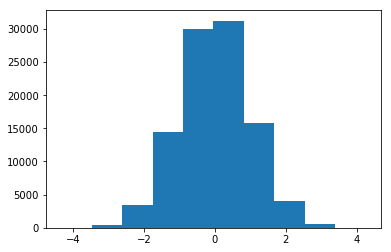

In [25]:
import numpy as np

from matplotlib import pyplot as plt
x = np.random.randn(100000)
plt.hist(x)
plt.show()



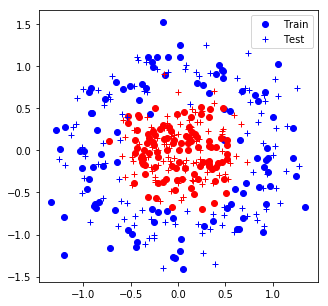

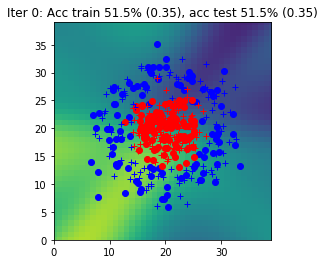

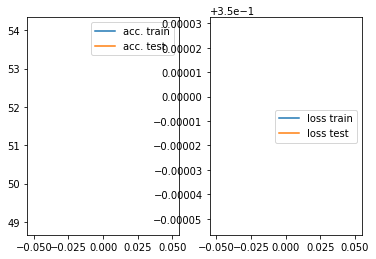

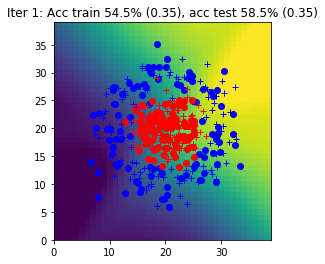

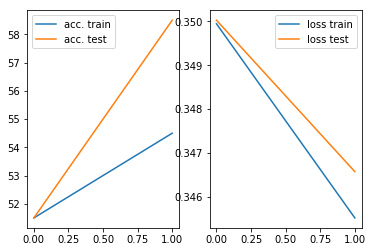

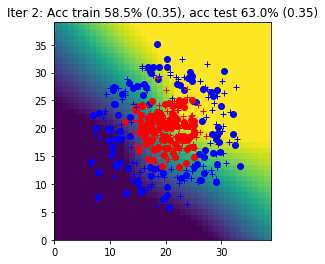

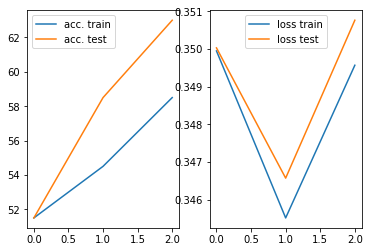

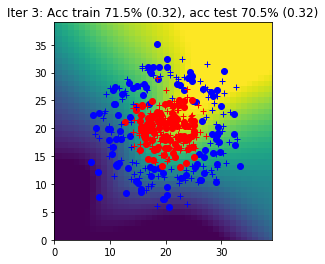

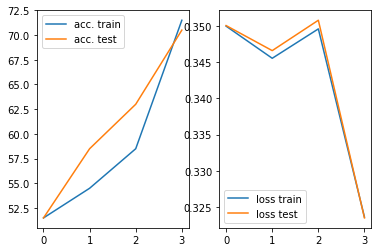

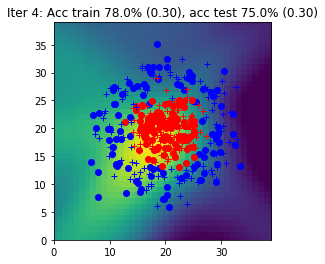

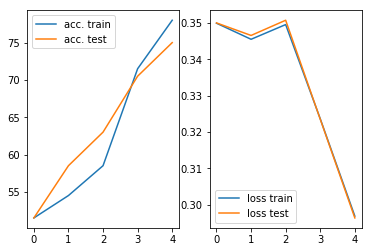

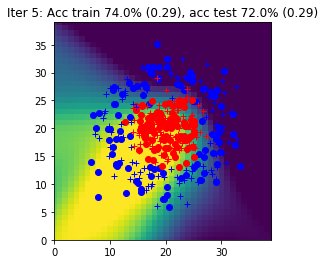

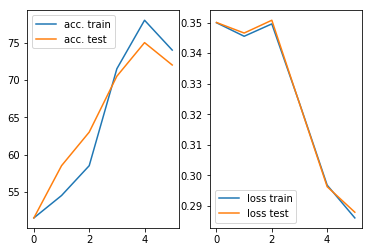

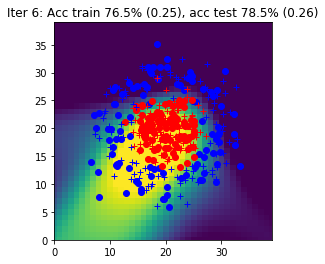

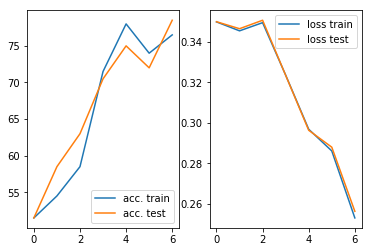

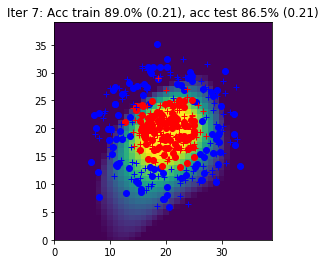

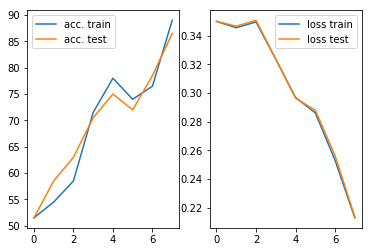

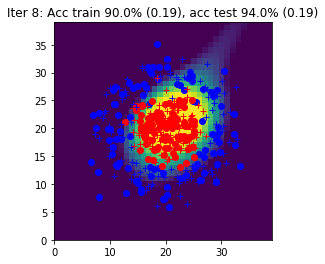

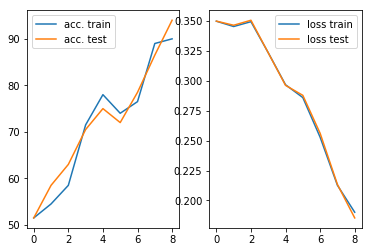

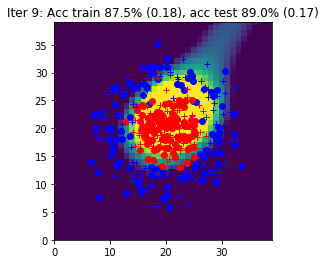

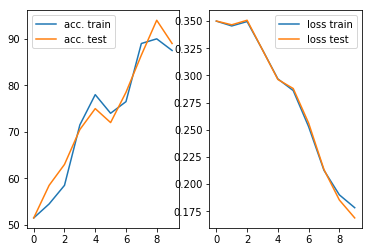

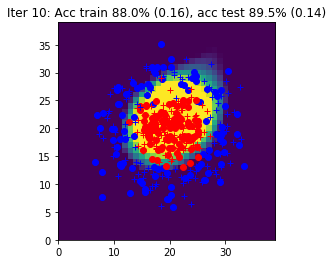

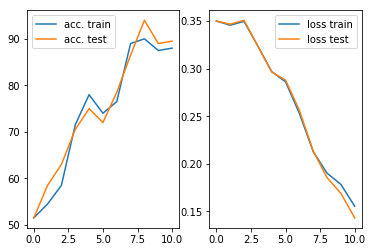

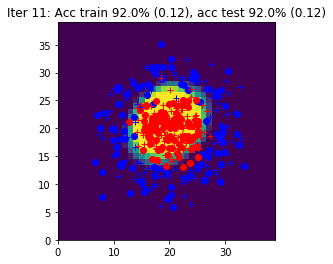

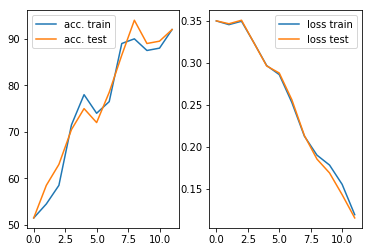

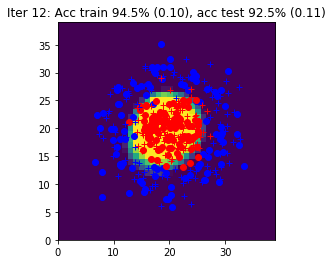

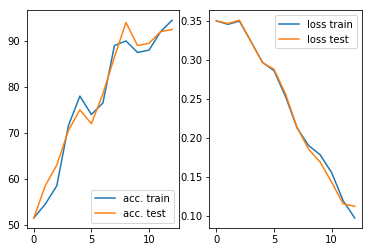

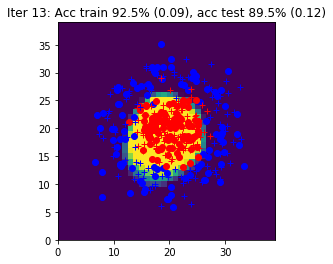

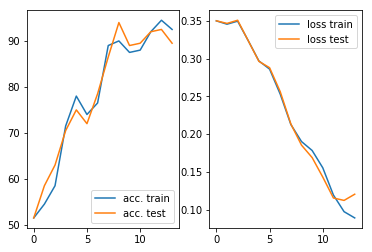

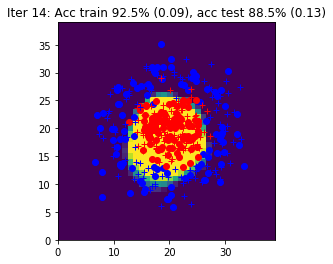

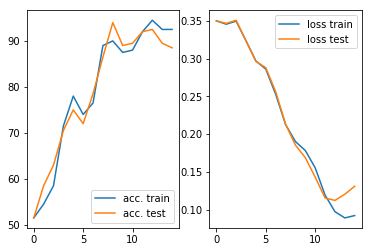

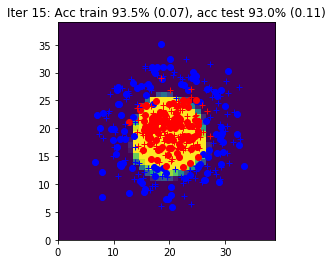

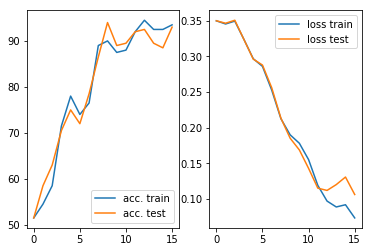

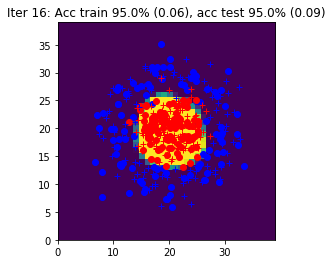

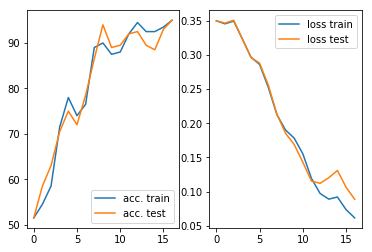

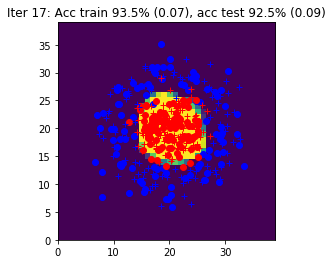

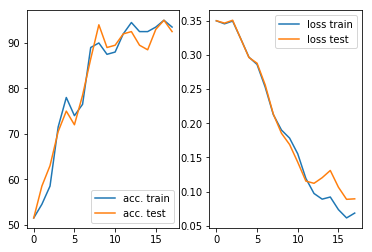

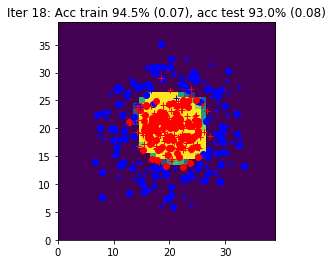

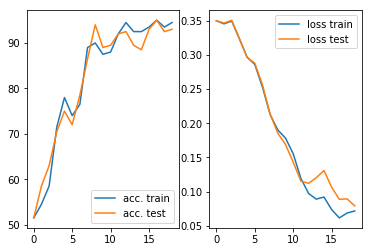

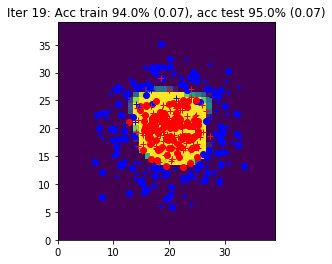

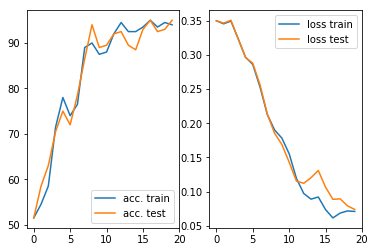

In [13]:
import torch
import numpy as np
from tme6 import CirclesData
from torch.autograd import Variable

def loss_accuracy(Yhat, Y):
    L = - torch.mean(Y * torch.log(Yhat))

    _, indYhat = torch.max(Yhat, 1)
    _, indY = torch.max(Y, 1)

    acc = torch.sum(indY == indYhat) #* 100 / indY.size(0);
    acc = float(acc.data[0]) * 100./indY.size(0)

    return L, acc

def init_params_auto(nx, nh, ny):
    params = {}
    params['Wh'] = Variable(torch.randn(nh, nx), requires_grad=True)
    params['bh'] = Variable(torch.zeros(nh, 1), requires_grad=True)
    params['Wy'] = Variable(torch.randn(ny, nh) * 0.3, requires_grad=True)
    params['by'] = Variable(torch.zeros(ny, 1),requires_grad=True)
    return params

def forward(params, X):
    bsize = X.size(0)
    nh = params['Wh'].size(0)
    ny = params['Wy'].size(0)
    outputs = {}
    outputs['X'] = X
    outputs['htilde'] = torch.mm(X, params['Wh'].t()) + params['bh'].t().expand(bsize, nh)
    outputs['h'] = torch.tanh(outputs['htilde'])
    outputs['ytilde'] = torch.mm(outputs['h'], params['Wy'].t()) + params['by'].t().expand(bsize, ny)
    outputs['yhat'] = torch.exp(outputs['ytilde'])
    outputs['yhat'] = outputs['yhat'] / (outputs['yhat'].sum(1, keepdim=True)).expand_as(outputs['yhat'])
    return outputs['yhat'], outputs

def sgd(params, eta=0.05):
    params['Wy'].data -= eta * params['Wy'].grad.data
    params['Wh'].data -= eta * params['Wh'].grad.data
    params['by'].data -= eta * params['by'].grad.data
    params['bh'].data -= eta * params['bh'].grad.data
    return params

data = CirclesData()
data.plot_data()

# init
N = data.Xtrain.shape[0]
Nbatch = 20
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eps = 30
params = init_params_auto(nx, nh, ny)


for iteration in range(20):

    perm = torch.randperm(N)
    Xtrain = data.Xtrain[perm]
    Ytrain = data.Ytrain[perm]

    # batches
    for j in range(N // Nbatch):
        X = Xtrain[perm[j * Nbatch:(j+1) * Nbatch]]
        Y = Ytrain[perm[j * Nbatch:(j+1) * Nbatch]]
        Yhat, outputs = forward(params, Variable(X, requires_grad=False))
        L, _ = loss_accuracy(Yhat, Variable(Y, requires_grad=False))
        L.backward()
        params = sgd(params, 0.03)

    Yhat_train, _ = forward(params, Variable(data.Xtrain, requires_grad=False))
    Yhat_test, _ = forward(params, Variable(data.Xtest, requires_grad=False))
    Ltrain, acctrain = loss_accuracy(Yhat_train, Variable(data.Ytrain, requires_grad=False))
    Ltest, acctest = loss_accuracy(Yhat_test, Variable(data.Ytest, requires_grad=False))
    Ygrid, _ = forward(params, Variable(data.Xgrid, requires_grad=False))

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain.data[0], acctest, Ltest.data[0])
    #print(title)
    data.plot_data_with_grid(Ygrid.data, title)
    L_train = Ltrain.data[0]
    L_test = Ltest.data[0]
    data.plot_loss((Ltrain.data[0]), (Ltest.data[0]), acctrain, acctest)

In [16]:
import torch
import numpy as np
from tme6 import CirclesData
from torch.autograd import Variable

def init_model(nx,nh,ny):
    model = torch.nn.Sequential(
        torch.nn.Linear(nx,nh),
        torch.nn.Tanh(),
        torch.nn.Linear(nh,ny)
    )
    loss = torch.nn.CrossEntropyLoss()
    return model, loss

def sgd(model,eta=0.03):
    for param in model.parameters():
        param.data -= eta*param.grad.data
    model.zero_grad()

data = CirclesData()
Y = data.Ytrain

# init
N = data.Xtrain.shape[0]
Nbatch = 20
nx = data.Xtrain.shape[1]
nh = 5
ny = data.Ytrain.shape[1]
model,loss = init_model(nx,nh,ny)
softmax = torch.nn.Softmax()

for iteration in range(20):

    perm = torch.randperm(N)
    Xtrain = data.Xtrain[perm]
    Ytrain = data.Ytrain[perm]

    # batches
    for j in range(N // Nbatch):
        X = Xtrain[perm[j * Nbatch:(j+1) * Nbatch]]
        Y = Ytrain[perm[j * Nbatch:(j+1) * Nbatch]]
        _,Yind = torch.max(Y, 1)
        Yhat = model(Variable(X, requires_grad=False))
        L = loss(Variable(Yind, requires_grad=False),Yhat)
        L.backward()
        sgd(model)

    Yhat_train = model(Variable(data.Xtrain, requires_grad=False))
    Yhat_test = model(Variable(data.Xtest, requires_grad=False))
    Ltrain, acctrain = loss_accuracy(Yhat_train, Variable(data.Ytrain, requires_grad=False))
    Ltest, acctest = loss_accuracy(Yhat_test, Variable(data.Ytest, requires_grad=False))
    Ygrid = model(Variable(data.Xgrid, requires_grad=False))
    Ygrid = softmax(Ygrid)

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain.data[0], acctest, Ltest.data[0])
    data.plot_data_with_grid(Ygrid.data, title)
    data.plot_loss((Ltrain.data[0]), (Ltest.data[0]), acctrain, acctest)


AssertionError: nn criterions don't compute the gradient w.r.t. targets - please mark these variables as volatile or not requiring gradients

Variable containing:
nan
[torch.FloatTensor of size 1]



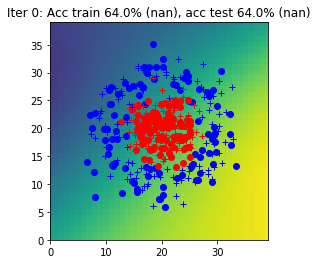

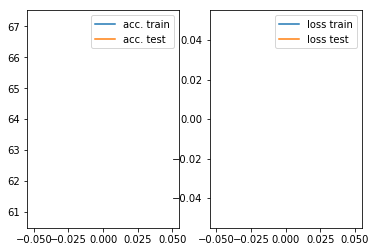

Variable containing:
nan
[torch.FloatTensor of size 1]



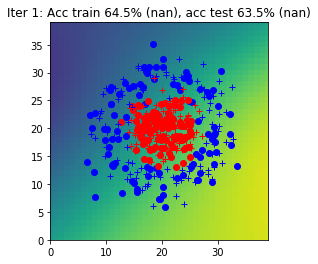

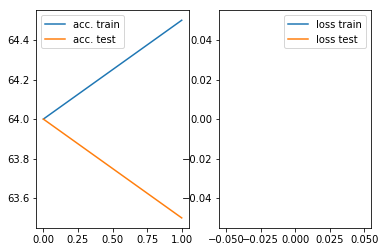

Variable containing:
nan
[torch.FloatTensor of size 1]



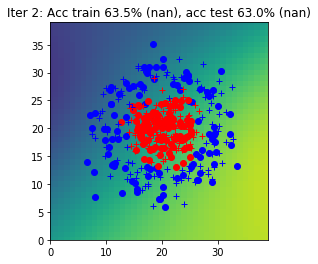

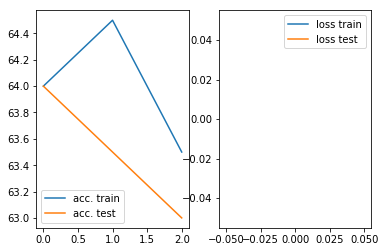

Variable containing:
nan
[torch.FloatTensor of size 1]



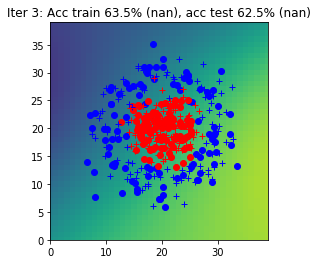

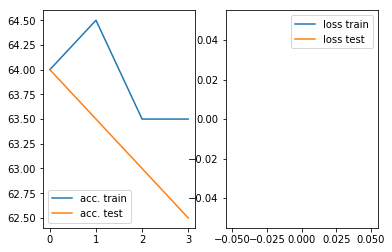

Variable containing:
nan
[torch.FloatTensor of size 1]



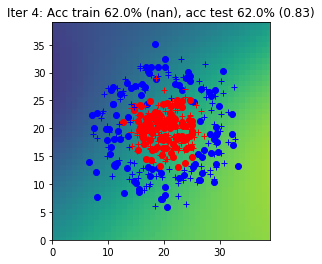

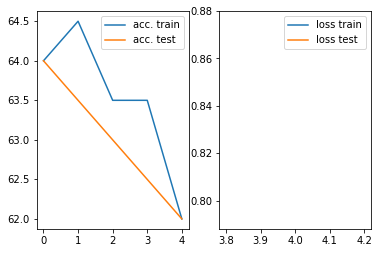

Variable containing:
nan
[torch.FloatTensor of size 1]



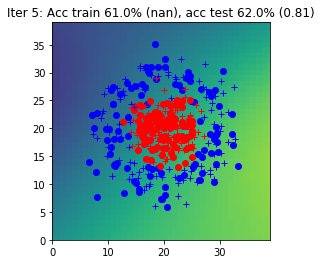

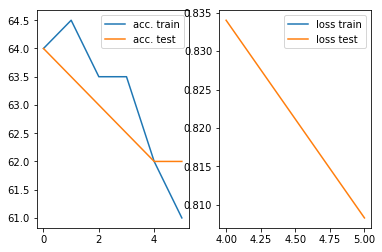

Variable containing:
nan
[torch.FloatTensor of size 1]



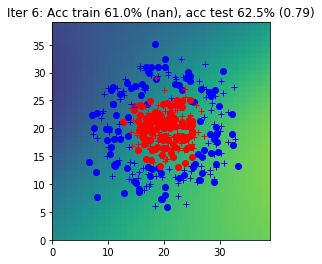

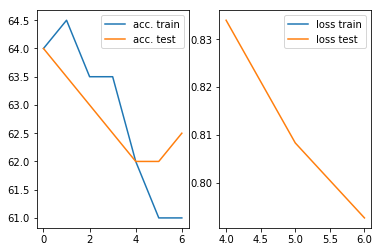

Variable containing:
 0.7811
[torch.FloatTensor of size 1]



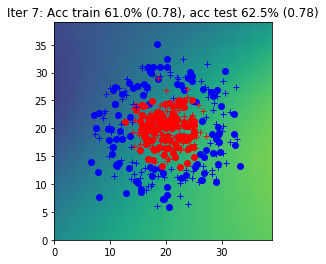

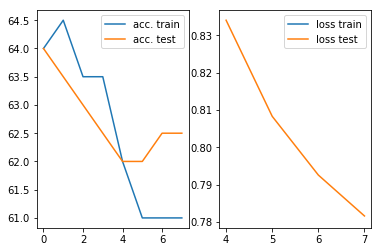

Variable containing:
 0.7747
[torch.FloatTensor of size 1]



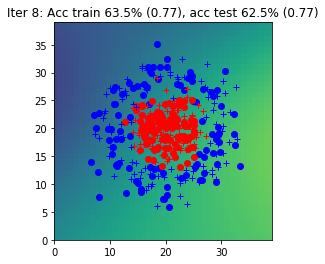

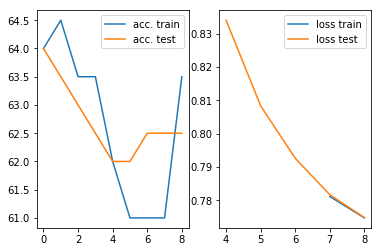

Variable containing:
 0.7671
[torch.FloatTensor of size 1]



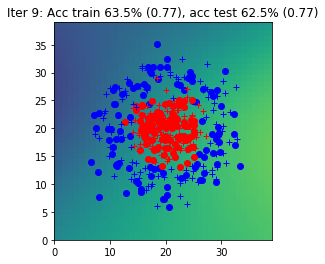

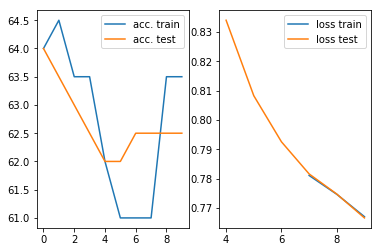

Variable containing:
 0.7605
[torch.FloatTensor of size 1]



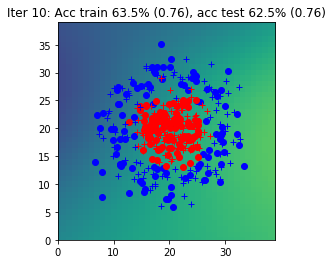

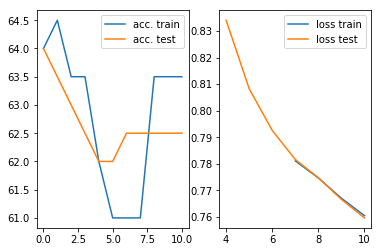

Variable containing:
 0.7538
[torch.FloatTensor of size 1]



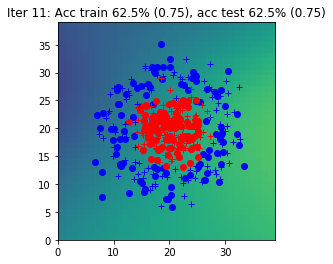

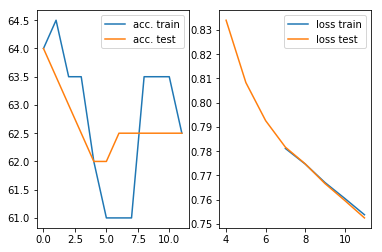

Variable containing:
 0.7507
[torch.FloatTensor of size 1]



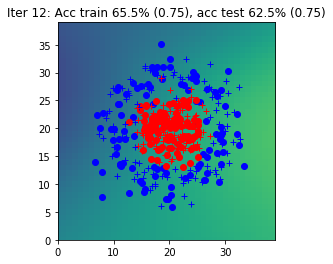

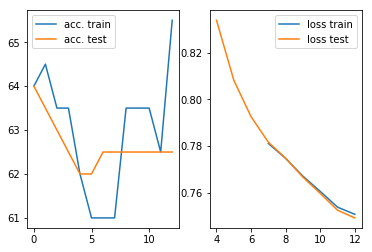

Variable containing:
 0.7473
[torch.FloatTensor of size 1]



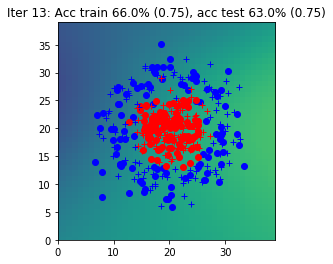

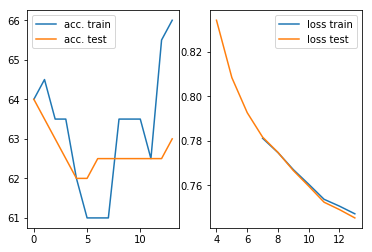

Variable containing:
 0.7448
[torch.FloatTensor of size 1]



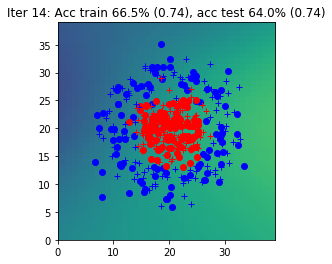

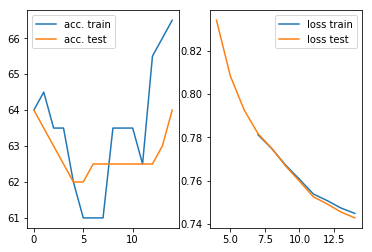

Variable containing:
 0.7404
[torch.FloatTensor of size 1]



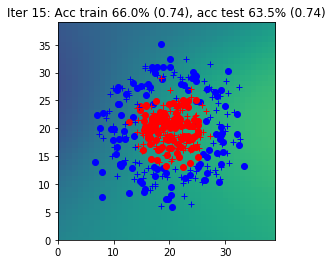

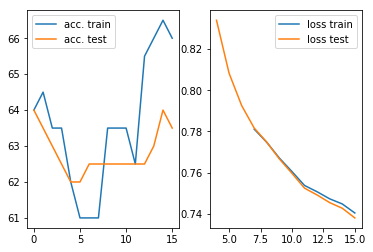

Variable containing:
 0.7364
[torch.FloatTensor of size 1]



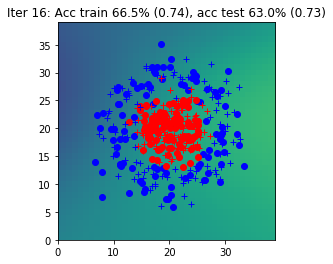

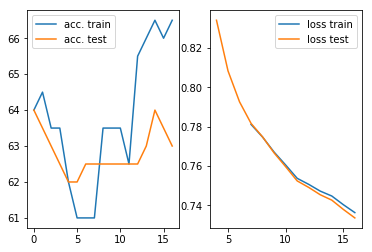

Variable containing:
 0.7344
[torch.FloatTensor of size 1]



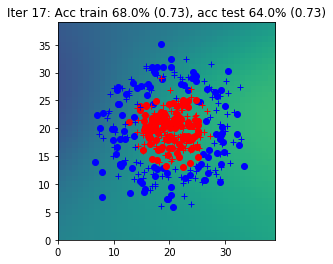

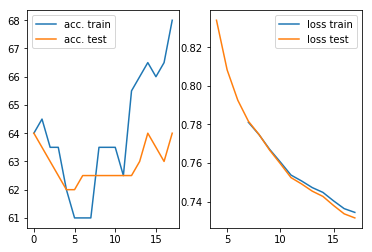

Variable containing:
 0.7314
[torch.FloatTensor of size 1]



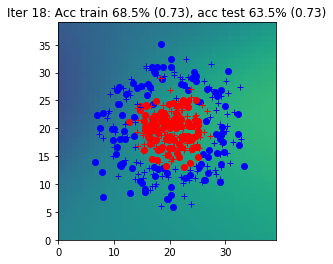

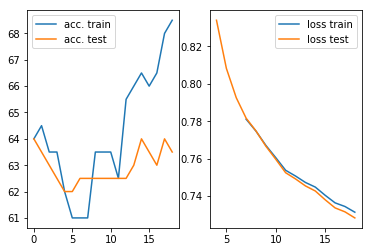

Variable containing:
 0.7298
[torch.FloatTensor of size 1]



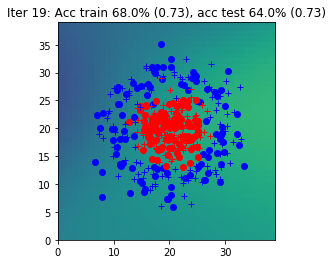

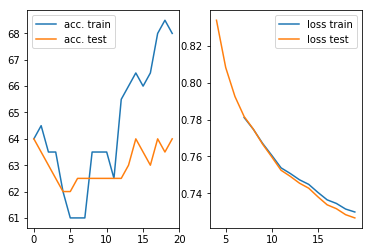

In [20]:
import torch
import numpy as np
from tme6 import CirclesData
from torch.autograd import Variable

def loss_accuracy(Yhat, Y):
    L = - torch.mean(Y * torch.log(Yhat))

    _, indYhat = torch.max(Yhat, 1)
    _, indY = torch.max(Y, 1)

    acc = torch.sum(indY == indYhat)
    acc = float(acc.data[0]) * 100./indY.size(0)

    return L, acc

def init_model(nx,nh,ny):
    model = torch.nn.Sequential(
        torch.nn.Linear(nx,nh),
        torch.nn.Tanh(),
        torch.nn.Linear(nh,ny)
    )
    loss = torch.nn.CrossEntropyLoss()
    return model, loss

def sgd(model,eta=0.03):
    for param in model.parameters():
        param.data -= eta*param.grad.data
    model.zero_grad()

data = CirclesData()
Y = data.Ytrain

# init
N = data.Xtrain.shape[0]
Nbatch = 20
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
model,loss = init_model(nx,nh,ny)
softmax = torch.nn.Softmax()

for iteration in range(20):

    perm = torch.randperm(N)
    Xtrain = data.Xtrain[perm]
    Ytrain = data.Ytrain[perm]

    # batches
    for j in range(N // Nbatch):
        X = Xtrain[perm[j * Nbatch:(j+1) * Nbatch]]
        Y = Ytrain[perm[j * Nbatch:(j+1) * Nbatch]]
        _,Yind = torch.max(Y, 1)
        Yhat = model(Variable(X, requires_grad=False))
        L = loss(Yhat, Variable(Yind, requires_grad=False))
        L.backward()
        sgd(model)

    Yhat_train = model(Variable(data.Xtrain, requires_grad=False))
    Yhat_test = model(Variable(data.Xtest, requires_grad=False))
    Ltrain, acctrain = loss_accuracy(Yhat_train, Variable(data.Ytrain, requires_grad=False))
    Ltest, acctest = loss_accuracy(Yhat_test, Variable(data.Ytest, requires_grad=False))
    Ygrid = model(Variable(data.Xgrid, requires_grad=False))
    Ygrid = softmax(Ygrid)
    
    print(Ltrain)

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain.data[0], acctest, Ltest.data[0])
    data.plot_data_with_grid(Ygrid.data, title)
    data.plot_loss((Ltrain.data[0]), (Ltest.data[0]), acctrain, acctest)
